# Yahoo Text Classification: ULMFiT vs BERT

**NOTE: This notebook has been executed in Google Colab Pro Edition, reduce max_len in BERT model to avoid resource runout error.**

~ By Nakshatra Singh

# Introduction
Text classification is a classic Natural Language Processing (NLP) problem. The task is to assign predefined categories to a given text sequence. 

Tasks involved in this notebook:
1. General Classification 
2. Language Modelling 
3. Text Classification

# Interesting Questions
## 1. Ask yourself why would they have selected this problem for the challenge? What are some gotchas in this domain I should know about?

Ans: Text classification is the task of assigning a sentence or document to an appropriate category. The categories depend on the chosen dataset and can range from topics. Text Classification, both through supervised and unsupervised approach, finds application in various fields such as social media, marketing, customer experience management, digital media etc. This task is currently in SOTA, performaces are different for different complexities of data and the architecture used.

Domains envisioned: NLP, supervised learning, Attention Mechanism, Transformer, Tokenization, RNN, LSTM 

## 2. What is the highest level of accuracy that others have achieved with this dataset or similar problems / datasets ?
Note: These results are obtained by using the whole dataset without dropping any rows.

\# | Dataset | Model | Eval Metric | Value
--- | --- | --- | --- | ---
01 | AG News | XLNet | Error | 4.8
02 | DBPedia | XLNet | Error | 0.62
03 | TREC-6 | USE + CNN | Error | 1.93
04 | 20NEWS | SSGC | Accuracy | 88.6
05 | Yahoo! Answers | BERT | Accuracy | 77.62
06 | YELP-5 | HAHNN | Accuracy | 73.28

## 3. What types of visualizations will help me grasp the nature of the problem / data?
Ans: 
1. Distributions to charts to check class balance

2. Distributions to charts to check where most nan values are present

3. Boxplots to visualize question lengths per category

4. Check class distribution for nan columns

5. Wordcloud visualization for most common words in the corpus

6. T-SNE visualization of target clusters using plotly (optional)

## 4. What feature engineering might help improve the signal? 

Ans: Combining all textual data to one column will help increase the corpus size and also increase relevant information for the target variable.

## 5. Which modeling techniques are good at capturing the types of relationships I see in this data?

Ans: Language models, SOTA transformers like BERT, GPT-2, GPT-3, XLM, ROBERTa, XLNet and RNNs', LSTMs', GRUs'.

## 6. Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!

Ans: We can perform hypothesis testing using custom examples and feed it the model to check the results with confidence score and target class.

## 7. What are some of the weaknesses of the model and and how can the model be improved with additional work

Ans: I will be using ULMFiT and BERT models to compare my results. ULMFiT uses a language model and a classifier model to predict the classes. The ULMFiT langauge model is performing quite bad in terms of accuracy for this dataset (100000 rows only) but the accuracy model is doing great compared to current benchmarks on Yahoo! Answers dataset. The BERT model performs better than the ULMFiT model and is also the current best SOTA model for this dataset. 

ULMFiT is getting confused between few example, when I input the model with text as: **'homebrew is not working on macosx'** the ULTFiT model predicts the class as **'Education & Reference' with 35% confidence score** where the BERT model predicts **['Computers & Internet'] with 97% confidence**. In real-life scenario, the ULMFiT model prediction seems to correct. As homebrew and MacOSX strings may/may not come under **'Education & Reference'**. On the other hand, BERT seems to do a great job is predicting the classes accurately with a good confidence. 

ULMFiT can be improved if more dataset is passed for the language model. Fine-tuning the parameters using optuna can also slightly increase the accuracy. But overall, BERT is the clear winner for this task.

# Data Description

The **Yahoo! Answers topic classification dataset** is constructed using 10 largest main categories. Each class contains 140,000 training samples and 6,000 testing samples. Therefore, the total number of training samples is 1,400,000 and testing samples 60,000 in this dataset. From all the answers and other meta-information, we only used the best answer content and the main category information.

The file `classes.txt` contains a list of classes corresponding to each label. 

The files `train.csv` and `test.csv` contain all the training samples as comma-sparated values. There are 4 columns in them, corresponding to class index (1 to 10), question title, question content and best answer. The text fields are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

We'll start by mounting my google drive to colab, the dataset has been downloaded from [fastai](https://course.fast.ai/datasets#nlp). 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')  

Mounted at /content/drive


# EDA

Let's explore the data using matplotlib and seaborn

In [ ]:
#@ Imports for data exploaration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
%matplotlib inline 

In [ ]:
#@ Converting integers to strings to understand each label independently.
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'} 

In [ ]:
#@ Load raw training data using pandas
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/train.csv',
                       names=['class', 'title', 'content', 'answer'])

#@ Mapping dict to target
raw_data['class'] = raw_data['class'].map(categories)
raw_data.head(3) 

,class,title,content,answer
0,Computers & Internet,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,Sports,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,Health,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...


NaN values present?

In [ ]:
raw_data.isna().sum() 

class           0
title           0
content    631675
answer      24579
dtype: int64

We'll deal with this in preprocessing. Let's proceed with EDA

In [ ]:
#@ Add question length
raw_data['length'] = raw_data.loc[:, 'content'].astype(str).apply(len)

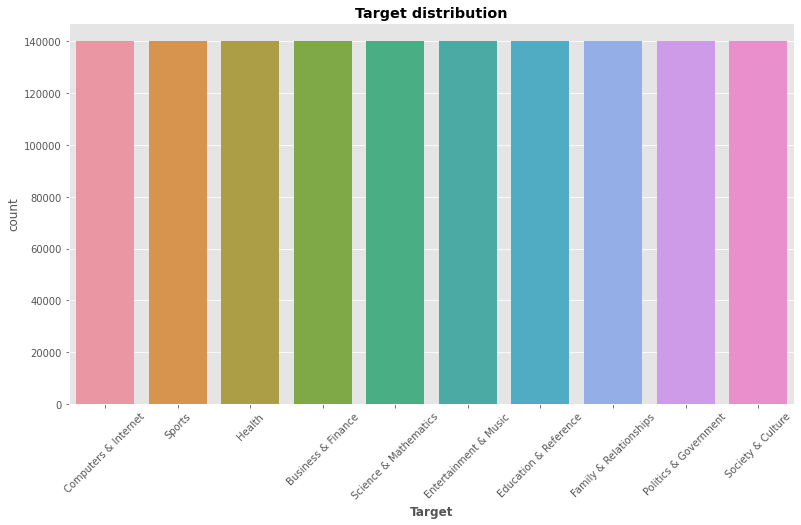

In [ ]:
#@ Target distribution 
plt.figure(figsize=(13, 7)) 
plt.style.use('ggplot')
sns.countplot(x = 'class', data = raw_data)
plt.title('Target distribution', fontweight='bold')
plt.xlabel('Target', fontweight='bold')
plt.xticks(rotation=45); 

Insights from chart above:
1. No NaN values in target
2. All the classes are equally distributed
3. No need to use SMOTE since balanced

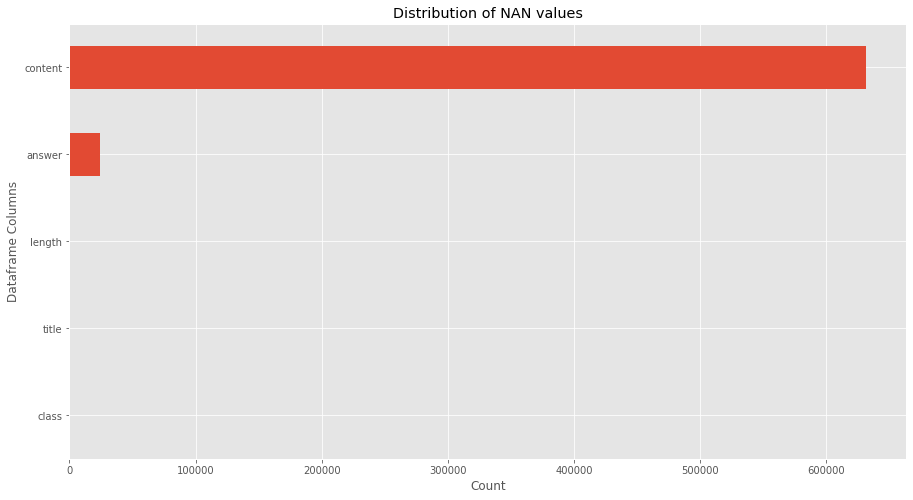

In [ ]:
#@ Exploring NaN values in dataset
fig = plt.figure(figsize=(15, 8))
plt.title("Distribution of NAN values")
plt.xlabel('Count')
plt.ylabel('Dataframe Columns') 
raw_data.isna().sum().sort_values(ascending = True).plot(kind = 'barh')
plt.show();

Insights from chart above:
1. Almost 46% of the data is missing in content column
2. Around 0.017% of the data is missing in answers column
3. We'll drop nan values of content column in preprocessing, this will save us compute and remove irrelavant information

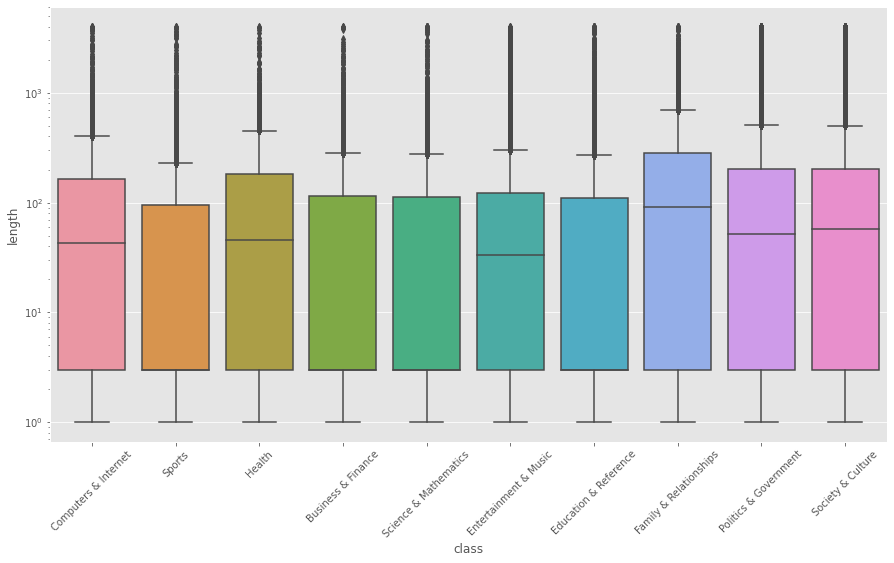

In [ ]:
#@ Boxplot of question lengths per category
plt.figure(figsize=(15, 8))
g = sns.boxplot(x='class', y='length', data=raw_data)
g.set_yscale('log')
plt.xticks(rotation=45)
plt.show();

Insights from chart above:
1. Most lengthy questions were from Family & Relationships category
2. Least from sports

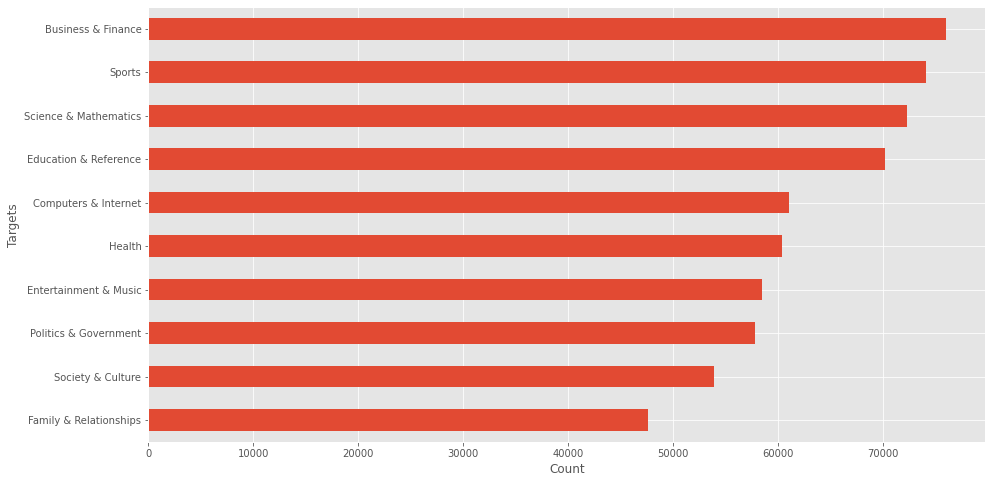

In [ ]:
#@ Checking class distribution of NaN values as content
fig = plt.figure(figsize=(15, 8))
data_isnull = raw_data[raw_data['content'].isnull()]
index = pd.Index(data_isnull['class'])
index.value_counts().sort_values(ascending = True).plot(kind = 'barh')
plt.ylabel('Targets') 
plt.xlabel('Count')
plt.show();  

Insights from chart above:
1. Most of the NaN values in content belongs to the Business & Finance class.
2. Least of the NaN values in content belongs to the Family & Relationships class. 

In [ ]:
#@ function to visualize word cloud for title - top occuring words in the corpus
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=40, 
        scale=3,
        random_state=1 
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show(); 

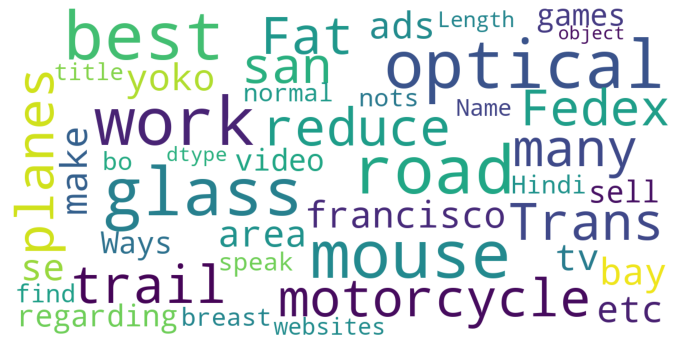

In [ ]:
#@ For title column
show_wordcloud(raw_data['title'])

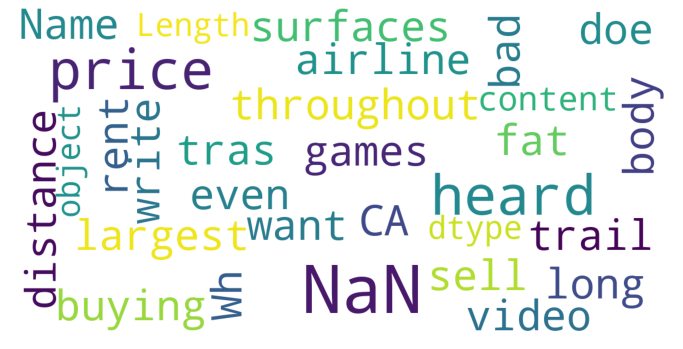

In [ ]:
#@ For content column
show_wordcloud(raw_data['content'])  

# Preprocessing

In [ ]:
#@ Imports for preprocessing data
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string     

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#@ Converting integers to strings to understand each label independently.
categories = {1: 'Society & Culture', 2: 'Science & Mathematics', 3: 'Health', 4: 'Education & Reference',
              5: 'Computers & Internet', 6: 'Sports', 7: 'Business & Finance', 8: 'Entertainment & Music',
              9: 'Family & Relationships', 10: 'Politics & Government'} 

In [ ]:
#@ Load raw training data using pandas
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/train.csv',
                       names=['class', 'title', 'content', 'answer'])

raw_data['class'] = raw_data['class'].map(categories)
raw_data.head(3) 

,class,title,content,answer
0,Computers & Internet,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,Sports,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,Health,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...


In [ ]:
raw_data.shape

(1400000, 4)

In [ ]:
#@ Remove all NaN values in content
data = raw_data[raw_data['content'].notnull()]  
data.shape 

(768325, 4)

In [ ]:
#@ Saving to csv
data.to_csv('yahoo_train_notnull.csv', index=False)  

In [ ]:
#@ Remove capitalization, stopwords, and punctuation
def process(text) : 
    #@ Remove punctuation/captizalization
    text = str(text)
    text = text.lower()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    #@ Remove stopwords
    procList = [word for word in nopunc.split() if word not in stopwords.words('english')]
    return ' '.join(procList)

def cleanAndSave(source, dest) : 
    #@ Load data
    df = pd.read_csv(source, names=['class', 'title', 'content', 'answer'])
    X1, X2, X3, Y = df['title'], df['content'], df['answer'], df['class']
    #@ Empty lists to append everything to one column
    title, question, answer, clss = [], [], [], []
    
    #@ Process text
    for i in range(0, len(X1)) :  
        title.append(process(X1[i]))
        question.append(process(X2[i]))
        answer.append(process(X3[i]))
        clss.append(Y[i])

    #@ Merge processed text columns into dataframe and save
    df = pd.DataFrame({"title" : title, "question" : question, "answer" : answer, "class" : clss})
    df['text'] = df['title'].map(str) + ' ' + df['question'].map(str) + ' ' + df['answer'].map(str)

    df_save = pd.DataFrame({'text': df['text'], "class" : df['class']})
    df_save.to_csv(dest, index=False)

cleanAndSave('/content/yahoo_train_notnull.csv', '/content/yahoo_train_notnull_clean.csv')
print('done') 

done


The above cell took around 4 hours to execute so I downloaded the preprocessed file from colab and saved in my drive.

# Modeling: Using ULMFiT for Text Classification with FastAI
ULMFiT, by Jeremy Howard et. al. from fast.ai, gives us an incredibly powerful method to classify text using language modelling and transfer learning. ULMFiT stands for Universal Language Model Fine-tuning for Text Classification and is a transfer learning technique that involves creating a Language Model that is capable of predicting the next word in a sentence, based on unsupervised learning of the WikiText 103 corpus. The ULMFiT model uses multiple LSTM layers, with dropout applied to every layer (the secret sauce), developed by Steve Merity (Salesforce) as the AWD-LSTM architecture.

In [ ]:
!nvidia-smi

Wed May 26 05:50:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1. Load the preprocessed data

In [ ]:
#@ Imports
from fastai.text import *    

In [ ]:
#@ Get cleaned dataset
path = '/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/yahoo_train_notnull_clean.csv'
cleaned_data = pd.read_csv(path) 

In [ ]:
#@ Fixing dataframe for ULMFiT
cleaned_data = cleaned_data.sample(frac=0.13).reset_index(drop=True)
cleaned_data = cleaned_data[['class', 'text']]
cleaned_data.head(2) 

,class,text
0,Family & Relationships,dont know think help please okay well boyfrien...
1,Computers & Internet,usb port dell computer one epson printer wont ...


In [ ]:
cleaned_data.shape 

(99882, 2)

### 2. Create train & validation datasets and FastAI data bunch

In [ ]:
from sklearn.model_selection import train_test_split

df_trn, df_val = train_test_split(cleaned_data, stratify = cleaned_data['class'], test_size = 0.3)

df_trn.shape, df_val.shape  

((69917, 2), (29965, 2))

Next, we will setup our data in the format that FastAI requires it to be in. FastAI provides simple functions to create Language Model and Classification “data bunch”.

Creating a data bunch automatically results in pre-processing of text, including vocabulary formation and tokenization.

TextLMDataBunch creates a data bunch for language modelling. In this, labels are completely ignored. Instead, data is processed so that the RNN can learn what word comes next given a starting word. Read the documentation [here](https://docs.fast.ai/text.data.html#TextLMDataBunch).

TextClasDataBunch sets up the data for classification. Labels play a key role here. We can also set the batch size for learning by changing the bs parameter. Read the documentation [here](https://docs.fast.ai/text.data.html#TextClasDataBunch).

In [ ]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "", vocab=data_lm.train_ds.vocab, bs=32)  

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


You can print out a sample of the batch using this line:

In [ ]:
data_clas.show_batch()  

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
xxbos somehow came across interesting website made atheist i m theist thought hoax bu 1 genesis 1 creation account conflicts order events known science genesis 11 earth created light stars birds whales reptiles insects flowering plants animals science know true order events xxunk “ and god said let light ” genesis 13 “ evening morning first day ” genesis 1 5 versus “ and god said ‘ let light firmament,Society & Culture
xxbos anyone know xxunk song xxunk i m want xxunk call do nt want hang upni say often ca nt xxunk answers would appreciated avant lie us feat nicole xxunk pussycat xxunk xxunk xxunk verse xxunk know started things did nt know babygirl got lotta things wenneed discuss know i m asking allot trust say things gettin old xxunk creepin love low xxunk ca nt wait till officially us ca,Entertainment & Music
xxbos find draft grammar check fourth para conclusion wrote alternative term please help use herbicide lawn care increased past year advertising portrayed herbicide magician could provide nice environment really short time order fulfill desire chemical spray use destroy needless weeds plants lot people overuse causes many problems problems typically found around us pollution water effects human health therefore responsibility prevent use herbicide protect life environment live xxunk contains two specific,Education & Reference
xxbos what s fastest way get swelling xxunk face got fight swollen eye might xxunk go work xxunk 5 days do nt want anyone notice smoke drink minimize amount two things interfere healing processes rob body oxygen water nutrients vitamins interferes healing xxunk check one woman asked similar question loaded great answers ice packs xxunk warm packs along using physicians makeup conceal many different types medications using xxunk cream say,Health
xxbos many us citizens living abroad countries us expats ideally looking breakdown us citizens living abroad country info long lived long plan continue live would helpful thanks 41 million americans excluding military live outside us 160 countries estimated 55 xxrep 4 0 military government personnel dependents also live abroad europe asia numbers known us state department estimates really around 66 million reason estimate exact many americans fall radar american living,Politics & Government


The xx___ tags represent the aspects of language in a way that the computer can understand. The xxbos tag marks the beginning of a sentence. The xxmaj tag is used to imply that the first letter of the next word is capitalized.
With this in place, we are ready to create a language model and classify!


In [ ]:
#@ Saving language model in drive
data_lm.save('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/data_lm_export.pkl')
data_clas.save('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/data_clas_export.pkl') 

In [ ]:
#@ Loading language model from drive
data_lm = load_data('./', '/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/data_lm_export.pkl')
data_clas = load_data('./', '/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/data_clas_export.pkl',bs=64)    

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### 3. Create and Train the Language Model

Creating a language model with the aforementioned AWD-LSTM model is done using the code below

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3) 

- data_lm is the language model data bunch
- AWD-LSTM is the model architecture
- drop_multi is the drop-out

Next up, let’s find the optimal learning rate to train our language model

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.74E-02


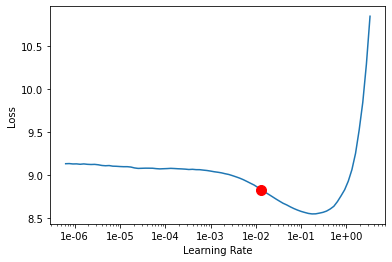

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr 

lr_find() is a built in fast.ai function that runs a few epochs on the model to plot loss, and then calculate the minimum gradient.

Now, let’s use this learning rate to train the language model:

In [ ]:
learn.fit_one_cycle(2, min_grad_lr)  

epoch,train_loss,valid_loss,accuracy,time
0,7.023629,6.735806,0.111317,04:04
1,6.551484,6.556456,0.119150,04:05


We can do a few more epochs after unfreezing all the layers. This process will train the whole neural network rather than just the last few layers. 

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, 1e-3)   

epoch,train_loss,valid_loss,accuracy,time
0,6.180114,6.442215,0.124212,04:31
1,5.969887,6.409162,0.126822,04:32


Our language model only achieved around 12% accuracy, but that is okay. This accuracy represents how well the model does at predicting the next word, given one word. And 12% means that 1 out of 2 times, the model accurately predicts the next word. Pretty impressive!

You can have some fun playing with the language model… here, we can ask the model to predict what comes after “How do”, till 10 words:

In [ ]:
learn.predict("How do", n_words=10) 

'How do nt wnat get advice hurt back well tell advice need'

Clearly, the sentence generated is not very meaningful, but it is grammatically accurate.

Finally, let’s save the language model encoder so that we can load it later in our classifier

In [ ]:
learn.save_encoder('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/ft_enc') 

### 4. Using the Language Model to Train the Classifier

Creating and training the the text classifier is very similar to training the language model.

Start by creating the text_classifier_learner with the data_clas DataBunch and the AWD_LSTM architecture. Then, you can load the language model encoder.

In [ ]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/ft_enc') 

RNNLearner(data=TextClasDataBunch;

Train: LabelList (69917 items)
x: TextList
xxbos apply credit card itin xxunk tax xxunk numbernif xxunk else yes good luck,xxbos get korean movie posters want get korean movie posters art seduction specific nwhere buy itnor better yet get xxunk available stores bookstores video rental places xxunk people video stores get posters anyway ebay google nno wayy kinda answer lolnnits hard get posters free npeople sell xxunk like every asian xxunk possible xxunk shipping is nt expencive poster prices kind high opinion unless rich xxunk ebay auction site yahoo amazon etc search people xxunk asian xxunk,xxbos deal spam says oops delete space com put website like xxunk com say delete space ca nt put url something spam filters right money assumption web email spam filters designed detect advertisements using sophisticated word detection syntax parameters one web addresses adding space address breaks flow address filter does nt know something assumed safety reas

Let’s again find the optimal learning rate to start with

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 3.63E-02


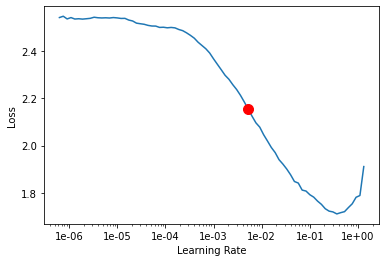

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr  

To train the classifier, we will use a technique called gradual unfreezing. We can start by training the last few layers, then go backwards and unfreeze and train layers before. We can use the learner function learn.freeze_to(-2) to unfreeze the last 2 layers.

In [ ]:
learn.fit_one_cycle(2, min_grad_lr) 

epoch,train_loss,valid_loss,accuracy,time
0,0.997400,0.863071,0.720808,01:22
1,0.990599,0.826184,0.730753,01:18


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

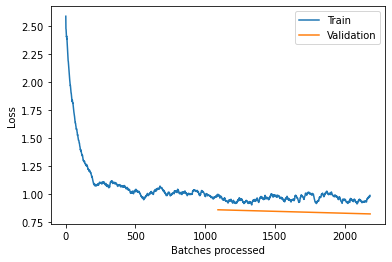

In [ ]:
learn.recorder.plot_losses() 

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(5e-3, 2e-3), moms=(0.8,0.7))  

epoch,train_loss,valid_loss,accuracy,time
0,0.955907,0.833245,0.730018,01:35
1,0.931088,0.803637,0.740230,01:28
2,0.807031,0.785144,0.746738,01:25
3,0.805810,0.782236,0.747439,01:24


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

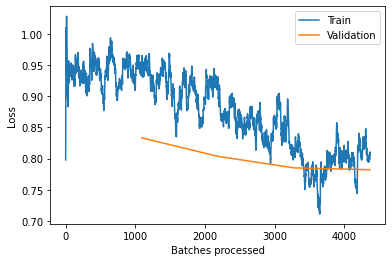

In [ ]:
learn.recorder.plot_losses()

Finally, let us unfreeze all layers and train the model at a low learning rate.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.769100,0.782119,0.749474,03:11
1,0.755485,0.773947,0.751777,02:55
2,0.727611,0.774901,0.753012,02:38
3,0.702299,0.781336,0.753679,02:54


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

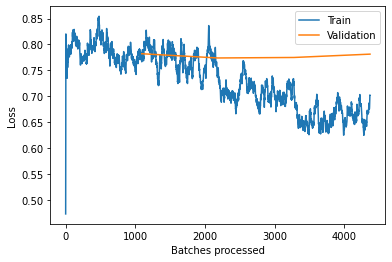

In [ ]:
learn.recorder.plot_losses() 

### 5. Analyzing our results

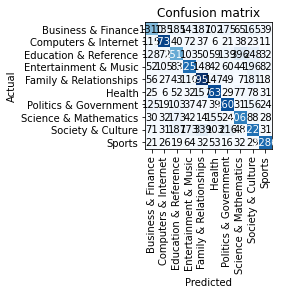

In [ ]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix() 

In [ ]:
preds,tensor,probs=learn.predict("football is really nice")
probs

tensor([6.8290e-03, 1.5123e-04, 2.2196e-03, 4.9810e-03, 1.8334e-03, 1.8030e-03,
        1.0691e-03, 5.7742e-04, 3.8475e-03, 9.7669e-01])

In [ ]:
preds,tensor,probs=learn.predict("football is really nice")
top_pred = probs.argsort(descending=True)[:1]
classes=learn.data.classes
labels = []
confidence = [] 
for i in top_pred:
  x = classes[i] 
  p = probs[i] 
  labels.append(x) 
  print("The following sentence belongs to", labels, "with confidence as", p)         

The following sentence belongs to ['Sports'] with confidence as tensor(0.9767)


In [ ]:
preds,tensor,probs=learn.predict("homebrew is not working on macosx")
top_pred = probs.argsort(descending=True)[:1]
classes=learn.data.classes
labels = []
confidence = [] 
for i in top_pred:
  x = classes[i] 
  p = probs[i] 
  labels.append(x) 
  print("The following sentence belongs to", labels, "with confidence as", p)        

The following sentence belongs to ['Education & Reference'] with confidence as tensor(0.3505)


# Modeling: Using BERT for Text Classification with Ktrain Wrapper

In [ ]:
!nvidia-smi

Wed May 26 08:08:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    38W / 250W |  15751MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@ Necessary installations
!pip install -q tensorflow==2.3.1 
!pip install -q ktrain==0.23.1 

     |████████████████████████████████| 320.4MB 46kB/s 
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 460kB 35.6MB/s 
     |████████████████████████████████| 2.9MB 31.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 25.3MB 50.0MB/s 
     |████████████████████████████████| 983kB 47.4MB/s 
     |████████████████████████████████| 266kB 22.3MB/s 
     |████████████████████████████████| 2.3MB 46.1MB/s 
     |████████████████████████████████| 471kB 36.2MB/s 
     |████████████████████████████████| 901kB 41.7MB/s 
     |████████████████████████████████| 3.3MB 40.9MB/s 


### 1. Load the preprocessed data

In [ ]:
#@ Imports
import ktrain 
from ktrain import text 
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [ ]:
#@ Get clean data
path = '/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/yahoo_train_notnull_clean.csv'
cleaned_data = pd.read_csv(path) 

In [ ]:
#@ Fix data for BERT model
cleaned_data = cleaned_data.sample(frac=0.13).reset_index(drop=True)
cleaned_data = cleaned_data[['class', 'text']]
cleaned_data.head(2) 

,class,text
0,Computers & Internet,helllp some1 msn sent link clicked downloaded ...
1,Education & Reference,math dragon riddle dragon captures two scienti...


### 2. Create train, validation & preprocessing datasets using texts_from_df in ktrain

In [ ]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=cleaned_data,
                                                                  text_column='text',
                                                                  label_columns='class',
                                                                  maxlen=64,
                                                                  preprocess_mode='bert')       

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


### 3. Create and Train the BERT Model

In [ ]:
model = text.text_classifier(name='bert',
                             train_data=(X_train, y_train),
                             preproc=preproc)  

Is Multi-Label? False
maxlen is 64
done.


In [ ]:
#@ Setting up learner
learner = ktrain.get_learner(model=model,
                             train_data=(X_train, y_train),
                             val_data=(X_test, y_test),
                             batch_size=64)   

In [ ]:
#@ Fitting model using one-cycle poliy, lr=2e-5 from research paper
learner.fit_onecycle(lr=2e-5, epochs=3); 



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
1405/1405 [==============================] - 835s 594ms/step - loss: 0.9965 - accuracy: 0.6873 - val_loss: 0.7922 - val_accuracy: 0.7485
Epoch 2/3
1405/1405 [==============================] - 828s 589ms/step - loss: 0.7199 - accuracy: 0.7716 - val_loss: 0.7388 - val_accuracy: 0.7640
Epoch 3/3
1405/1405 [==============================] - 824s 586ms/step - loss: 0.5698 - accuracy: 0.8193 - val_loss: 0.7567 - val_accuracy: 0.7656


In [ ]:
#@ Get predictor using preproc dataset
predictor = ktrain.get_predictor(learner.model, preproc)   

In [ ]:
classes = predictor.get_classes()  
classes

['Business & Finance',
 'Computers & Internet',
 'Education & Reference',
 'Entertainment & Music',
 'Family & Relationships',
 'Health',
 'Politics & Government',
 'Science & Mathematics',
 'Society & Culture',
 'Sports']

### 6. Experimenting results
Example 1.

In [ ]:
data = ["football is really nice"]  

In [ ]:
predictor.predict(data)

['Sports']

In [ ]:
data = ['football is really nice']
classes=predictor.predict(data)
probs=predictor.predict(data, return_proba=True) 
# probs = torch.Tensor(probs)
# top_pred = probs.argsort(descending=True)[:,0] 
print("The following sentence belongs to", classes, "with confidence:", probs.max())             

The following sentence belongs to ['Sports'] with confidence: 0.97864574


Example 2.

In [ ]:
data = ['homebrew is not working on macosx']

In [ ]:
predictor.predict(data)  

['Computers & Internet']

In [ ]:
data = ['homebrew is not working on macosx, can someone solve this problem?']
classes=predictor.predict(data)
probs=predictor.predict(data, return_proba=True) 
# probs = torch.Tensor(probs)
# top_pred = probs.argsort(descending=True)[:,0] 
print("The following sentence belongs to", classes, "with confidence:", probs.max()) 

The following sentence belongs to ['Computers & Internet'] with confidence: 0.9726442


Example.3

In [ ]:
data = ['im bored got the ideas two say hey to a monkey']
classes=predictor.predict(data)
probs=predictor.predict(data, return_proba=True) 
# probs = torch.Tensor(probs)
# top_pred = probs.argsort(descending=True)[:,0] 
print("The following sentence belongs to", classes, "with confidence:", probs.max()) 

The following sentence belongs to ['Entertainment & Music'] with confidence: 0.84202164


In [ ]:
#@ Saved in h5 format by default 
predictor.save('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/my_predictor') 

In [ ]:
# reloaded_predictor = ktrain.load_predictor('/content/drive/MyDrive/Colab Notebooks/Internships/Fellowship.ai/yahoo_answers_csv/my_predictor')